In [1]:
! pip install numpy h5py pandas

In [2]:
import h5py as h5  #for handling data format
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

In [3]:
def restrict(df, col, lower_limit, upper_limit):
    mask = (df[col] >= lower_limit) & (df[col] <= upper_limit)
    return df[mask]

In [19]:
def load_data(filename, mode, filter = 'True'):
    data = h5.File(filename)
    SP = data[mode + '_System_Parameters']

    if mode == 'BSE': 
        df = pd.DataFrame({
            'L1': SP['Luminosity(1)'][()],
            'L2': SP['Luminosity(2)'][()],
            'Teff1': SP['Teff(1)'][()],
            'Teff2': SP['Teff(2)'][()],
            'type1': SP['Stellar_Type(1)'][()],
            'type2': SP['Stellar_Type(2)'][()]
        })

        if filter:
            df = restrict(df, 'type1', 1, 1) #MS stars only
            df = restrict(df, 'type2', 1, 1) #MS stars only

    else:
        df = pd.DataFrame({
           'L': SP['Luminosity'][()],
           'Teff': SP['Teff'][()],
           'type': SP['Stellar_Type'][()]
        })

        if filter: 
            df = restrict(df, 'type', 1, 1) #MS stars only

    return df

Inspect the data:
Data_SSE  = h5.File('COMPAS_Output_SSE.h5')
list(Data_SSE.keys())

Inspect mergers:
CE_BSE = Data_BSE['BSE_Common_Envelopes']
#list(CE_BSE.keys())
merger = CE_BSE['Merger'][()]
print(merger.shape)     

Print log file keys (e.g. system parameter keys):
list(SP_BSE.keys())

Finding the unit of a parameter:
print(SP_BSE['Teff(1)'].attrs['units'])
print(SP_BSE['Luminosity(1)'].attrs['units'])

In [20]:
binary = load_data('new_output_BSE_!rot.h5', 'BSE')
single = load_data('COMPAS_Output_SSE.h5', 'SSE')

HRD (Main sequence)

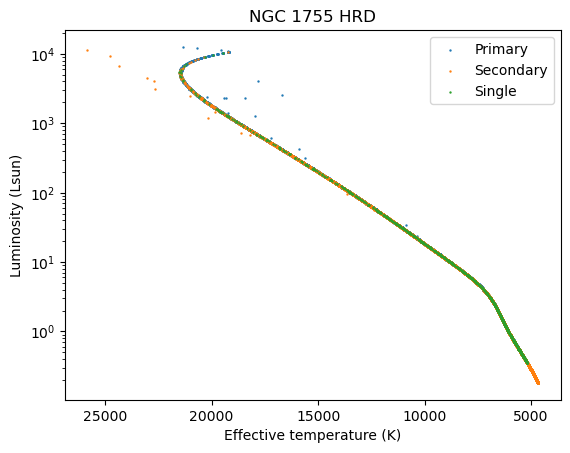

In [21]:
plt.scatter(binary.Teff1, binary.L1, label = 'Primary', s = 0.5)
plt.scatter(binary.Teff2, binary.L2, label = 'Secondary', s = 0.5)
plt.scatter(single.Teff, single.L, label = 'Single', s = 0.5)
plt.gca().invert_xaxis()
plt.title('NGC 1755 HRD')
plt.xlabel('Effective temperature (K)')
plt.ylabel('Luminosity (Lsun)')
plt.yscale('log')
plt.legend()

In [7]:
before = load_data('COMPAS_Output.h5', 'BSE')

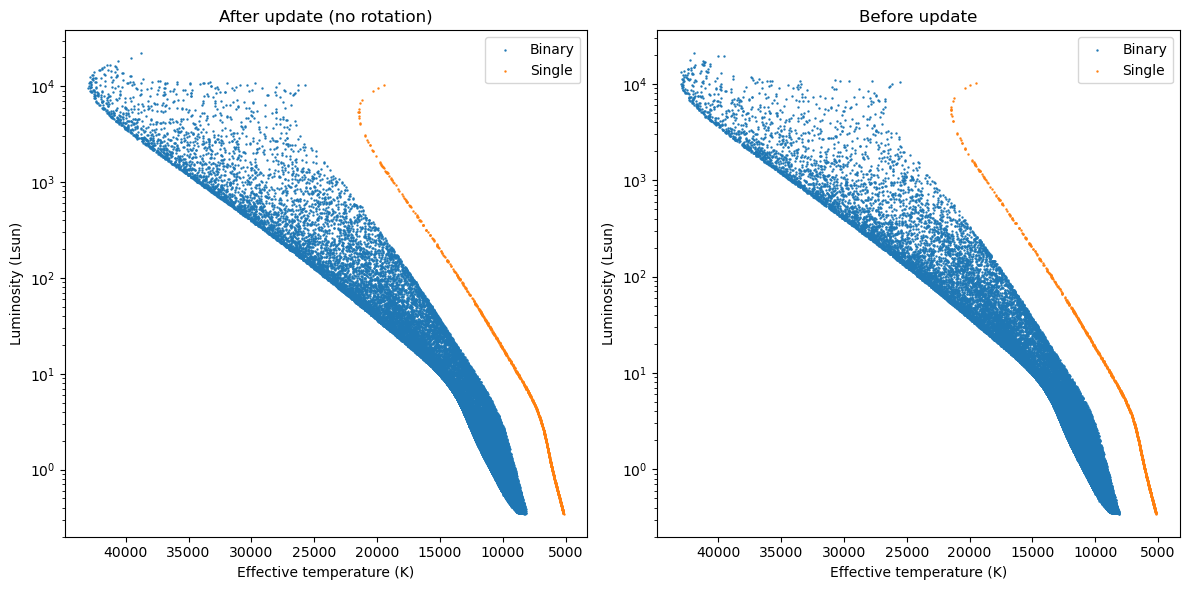

In [8]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
axes[0].scatter(binary.Teff, binary.L, label = 'Binary', s = 0.5)
axes[0].scatter(single.Teff, single.L, label = 'Single', s = 0.5)
axes[0].invert_xaxis()
axes[0].set_title('After update (no rotation)')
axes[0].set_xlabel('Effective temperature (K)')
axes[0].set_ylabel('Luminosity (Lsun)')
axes[0].set_yscale('log')
axes[0].legend()

axes[1].scatter(before.Teff, before.L, label = 'Binary', s = 0.5)
axes[1].scatter(single.Teff, single.L, label = 'Single', s = 0.5)
axes[1].invert_xaxis()
axes[1].set_title('Before update')
axes[1].set_xlabel('Effective temperature (K)')
axes[1].set_ylabel('Luminosity (Lsun)')
axes[1].set_yscale('log')
axes[1].legend()

fig.tight_layout()

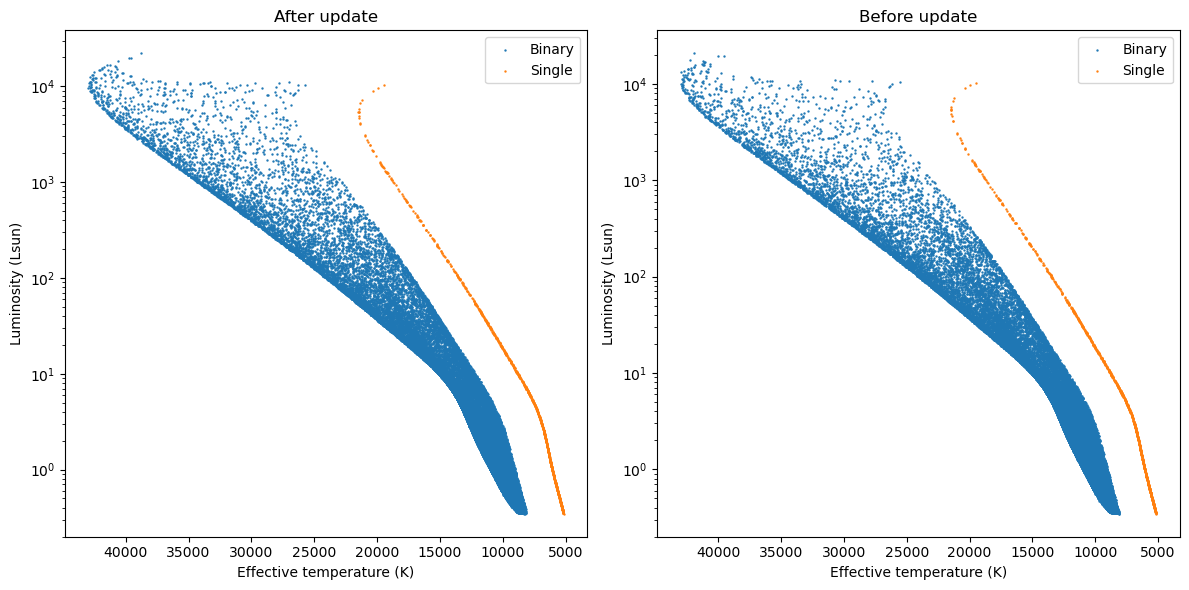

In [9]:
binary_rot = load_data('new_output_BSE.h5', 'BSE')

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
axes[0].scatter(binary_rot.Teff, binary_rot.L, label = 'Binary', s = 0.5)
axes[0].scatter(single.Teff, single.L, label = 'Single', s = 0.5)
axes[0].invert_xaxis()
axes[0].set_title('After update')
axes[0].set_xlabel('Effective temperature (K)')
axes[0].set_ylabel('Luminosity (Lsun)')
axes[0].set_yscale('log')
axes[0].legend()

axes[1].scatter(before.Teff, before.L, label = 'Binary', s = 0.5)
axes[1].scatter(single.Teff, single.L, label = 'Single', s = 0.5)
axes[1].invert_xaxis()
axes[1].set_title('Before update')
axes[1].set_xlabel('Effective temperature (K)')
axes[1].set_ylabel('Luminosity (Lsun)')
axes[1].set_yscale('log')
axes[1].legend()

fig.tight_layout()

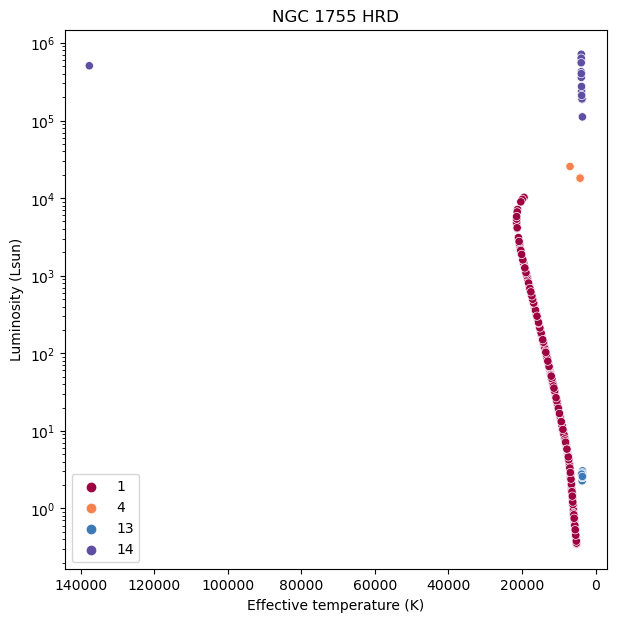

In [10]:
plt.figure(figsize=(7, 7))
sns.scatterplot(data=load_data('COMPAS_Output_SSE.h5', 'SSE', filter=False), x='Teff', y='L', hue='type', palette='Spectral', legend='full')
plt.gca().invert_xaxis()
plt.title('NGC 1755 HRD')
plt.xlabel('Effective temperature (K)')
plt.ylabel('Luminosity (Lsun)')
plt.yscale('log')
plt.legend()

In [11]:
df = pd.read_csv('n1755_decont.csv')
df = df.drop(columns = {'X', 'Y'})
df.head(3)

,F814W,F336W
0,20.7856,21.2180
1,20.5492,20.8215
2,21.4685,22.2934


Text(0.5, 1.0, 'NGC 1755')

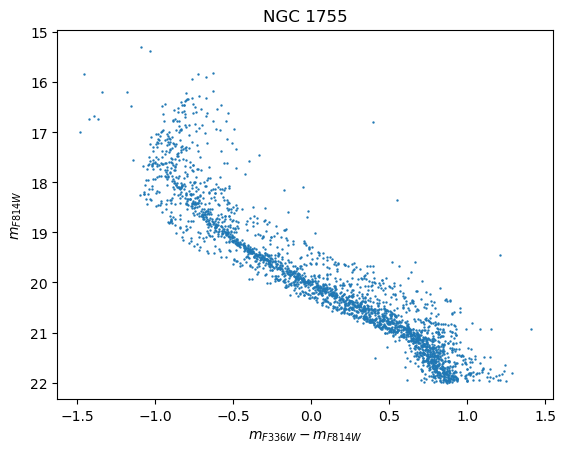

In [12]:
plt.scatter(df.F336W-df.F814W, df.F814W, s = 0.5)
plt.xlabel(r'$m_{F336W}-m_{F814W}$')
plt.ylabel(r'$m_{F814W}$')
plt.gca().invert_yaxis()
plt.title('NGC 1755')

In [13]:
def convert_to_lum(m):
  #refer to https://www.nature.com/articles/s41550-021-01597-5
  m = np.array(m)
  M = m - 18.29
  L = (3.0128e28)*np.power(10,-0.4*M) #in W
  L /= 3.827e+26 # in solar 
  return L

In [14]:
L = convert_to_lum(df.F814W)
L

array([  7.90445335,   9.82724629,   4.21416796, ..., 761.78398887,
       475.85193586, 486.26368894])

In [15]:
def convert_to_teff(mag_336, mag_814):
  colour = mag_336 - mag_814 # B - I 
  return 6800 - 4700*colour

def convert_to_teff(mag_336, mag_814):
  colour = mag_336 - mag_814 - 0.14
  return 4600*((1/(0.92*colour + 1.7)) + (1/(0.92*colour + 0.62)))

In [16]:
Teff = convert_to_teff(df.F336W, df.F814W)

Text(0.5, 1.0, 'NGC 1755')

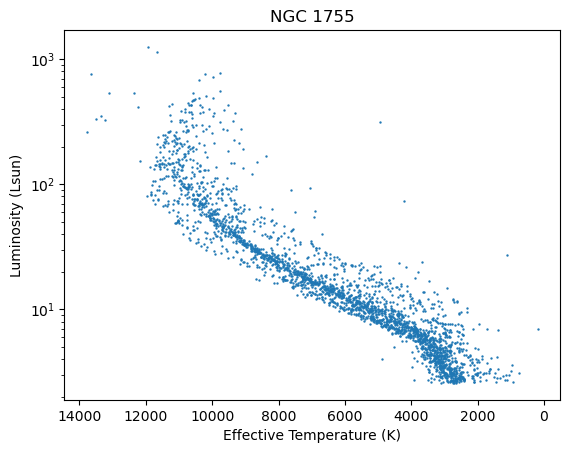

In [17]:
plt.scatter(Teff, L, s = 0.5)
plt.xlabel('Effective Temperature (K)')
plt.ylabel('Luminosity (Lsun)')
plt.gca().invert_xaxis()
plt.yscale('log')
plt.title('NGC 1755')

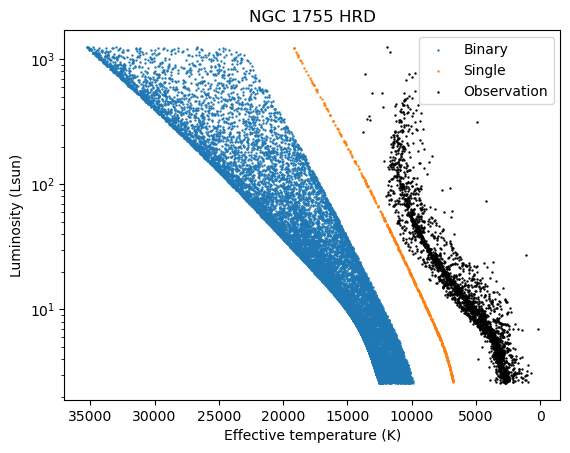

In [18]:
simul_SSE = restrict(single, 'Teff', np.min(Teff), np.max(Teff))
simul_SSE = restrict(single, 'L', np.min(L), np.max(L))
simul_BSE = restrict(binary_rot, 'Teff', np.min(Teff), np.max(Teff))
simul_BSE = restrict(binary_rot, 'L', np.min(L), np.max(L))

plt.scatter(simul_BSE.Teff, simul_BSE.L, label = 'Binary', s = 0.5)
plt.scatter(simul_SSE.Teff, simul_SSE.L, label = 'Single', s = 0.5)
plt.scatter(Teff, L, s = 0.5, c='k', label = 'Observation')
plt.gca().invert_xaxis()
plt.title('NGC 1755 HRD')
plt.xlabel('Effective temperature (K)')
plt.ylabel('Luminosity (Lsun)')
plt.yscale('log')
plt.legend()
